<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook, follow me on Kaggle and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 
### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [1]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'


## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [2]:
%%capture
!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [3]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
INPUT_DIR = '../input/sf-dst-predict-car-price/'

In [7]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [8]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [9]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


In [10]:
%%time
train_data = train_data.drop(index=17918)
print('Кол-во строк до',len( train_data))
train_data = train_data.drop('doors_cnt', axis=1)
train_data = train_data.drop('car_vin', axis=1)
train_data = train_data.reset_index()
print('Кол-во строк после',len(train_data))

Кол-во строк до 34999
Кол-во строк после 34999
CPU times: user 22.1 ms, sys: 5.29 ms, total: 27.4 ms
Wall time: 33.6 ms


In [11]:
train_data

,index,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
0,0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,Right-hand drive,Silver,Black,0,For Sale,3650.0
1,1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,Left wheel,Silver,Black,0,For Sale,6800.0
2,2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,Left wheel,Silver,Black,1,For Sale,6300.0
3,3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,Left wheel,Blue,Black,1,For Sale,14488.0
4,4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,Left wheel,Black,NaN,1,For Sale,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34994,34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,Left wheel,Black,NaN,1,For Sale,6000.0
34995,34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,Left wheel,Silver,Black,1,For Sale,9642.0
34996,34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,Left wheel,Grey,Grey,1,For Sale,23500.0
34997,34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,Left wheel,White,Black,1,For Sale,12826.0


In [12]:
%%time
# train_data = train_data.drop('level_0', axis=1)
print('Кол-во строк до',len( train_data))
#train_data = train_data.reset_index()
df_isnull = train_data.isnull()
ff = df_isnull[df_isnull['vehicle_model'] == True].index
for i in ff:
    train_data = train_data.drop(index=i)

train_data = train_data.reset_index()
print('Кол-во строк после 1 этапа', len(train_data))

Кол-во строк до 34999
Кол-во строк после 1 этапа 34993
CPU times: user 59.1 ms, sys: 1.88 ms, total: 61 ms
Wall time: 63.5 ms


In [13]:
%%time

import random
random.seed(42)
train_data = train_data.drop('level_0', axis=1)
df_isnull = train_data.isnull()
# функция поиска цвета по ключу
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
# вычисляем топовые цвета
pop_color_mask = train_data['vehicle_interior_color'].value_counts(normalize=True) > 0.01
color_list = pop_color_mask[pop_color_mask == True]
color_list = list(color_list.index)
# заполняем словарь цветом
dct = {}
for i in range(len(color_list)):
    dct[color_list[i]] = i

# заносим топовые цвета в пустые данные
cc = df_isnull[df_isnull['vehicle_interior_color'] == True].index
for i in cc:
    train_data.loc[i,'vehicle_interior_color'] = get_key(dct, random.randrange(0, len(color_list)))
print('Кол-во строк после 2 этапа', len(train_data))

Кол-во строк после 2 этапа 34993
CPU times: user 5.72 s, sys: 0 ns, total: 5.72 s
Wall time: 5.72 s


In [14]:
%%time

# вычисляем топовые цвета
v_pop_color_mask = train_data['vehicle_color'].value_counts(normalize=True) > 0.01
v_color_list = pop_color_mask[pop_color_mask == True]
v_color_list = list(v_color_list.index)
# заполняем словарь цветом
dct_v = {}
for i in range(len(v_color_list)):
    dct_v[v_color_list[i]] = i

# заносим топовые цвета в пустые данные
v_cc = df_isnull[df_isnull['vehicle_color'] == True].index
for i in v_cc:
    train_data.loc[i,'vehicle_color'] = get_key(dct_v, random.randrange(0, len(v_color_list)))
print('Кол-во строк после 3 этапа', len(train_data))

Кол-во строк после 3 этапа 34993
CPU times: user 342 ms, sys: 0 ns, total: 342 ms
Wall time: 342 ms


### Step 0.5. Some user feature preparation

Be creative :)

In [15]:
%%time

def create_expert_feats(data):
    pass

create_expert_feats(train_data)
create_expert_feats(test_data)

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 22.2 µs


### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [16]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (27994, 14), te_data = (6999, 14)


,index,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
32926,32933,32933,TOYOTA,Camry,Sedan,555555,2010,Automatic,Left wheel,White,Beige,1,For Rent,11.0
28581,28587,28587,LEXUS,RX 450,Jeep,59858,2016,Automatic,Left wheel,Silver,Grey,1,For Sale,3600.0
2982,2982,2982,TOYOTA,Prius,Sedan,170000,2010,Variator,Left wheel,Blue,Beige,0,For Sale,4600.0
32351,32357,32357,VAZ,2121 (Niva),Jeep,0,2018,Manual,Left wheel,Red,Beige,0,For Sale,383.0
28744,28750,28750,TOYOTA,Camry,Sedan,190549,2013,Automatic,Left wheel,Black,Black,1,For Sale,1600.0


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [17]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [18]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID','index']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [19]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [20]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[19:39:02] Stdout logging level is INFO.
[19:39:02] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[19:39:02] Task: reg

[19:39:02] Start automl preset with listed constraints:
[19:39:02] - time: 900.00 seconds
[19:39:02] - CPU: 4 cores
[19:39:02] - memory: 16 GB

[19:39:02] Train data shape: (27994, 14)

[19:39:10] Layer 1 train process start. Time left 891.80 secs
[19:39:11] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:39:27] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3910.538961577451
[19:39:27] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:39:27] Time left 874.93 secs

[19:39:31] Selector_LightGBM fitting and predicting completed
[19:39:33] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:39:55] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -2991.7607203723996
[19:39:55] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:39:55] Start hyperparameters optimization for Lvl_0_

In [21]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [22]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 1586.4534],
       [ 5869.412 ],
       [ 6665.004 ],
       ...,
       [ 1754.5135],
       [13888.232 ],
       [ 4557.9243]], dtype=float32)
Shape = (6999, 1)
CPU times: user 9.87 s, sys: 32.1 ms, total: 9.9 s
Wall time: 3.29 s


In [23]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 2861.552834496955
HOLDOUT score: 1580.7705785151993


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: user 131 ms, sys: 78.7 ms, total: 209 ms
Wall time: 133 ms


<AxesSubplot:xlabel='Feature'>

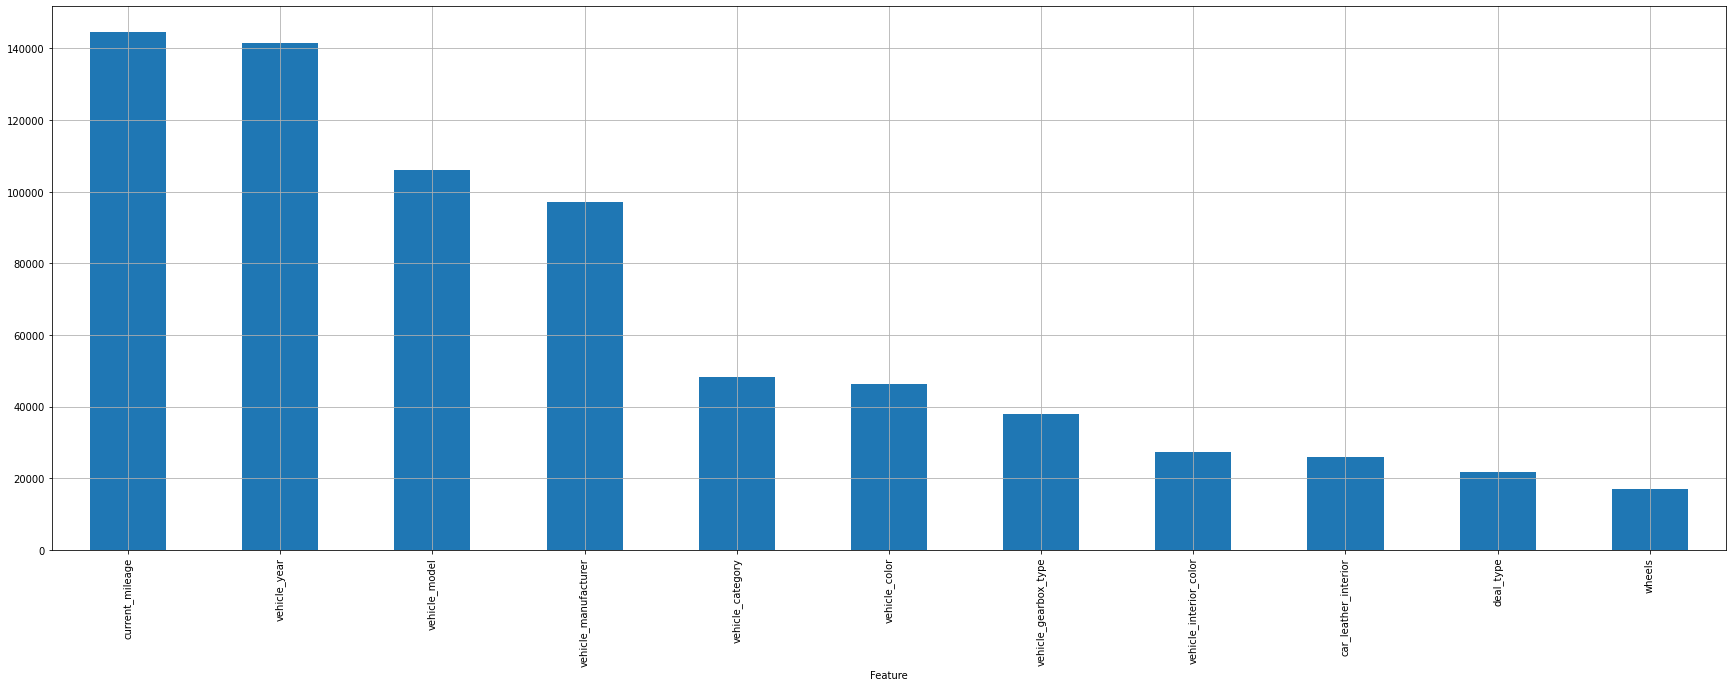

In [24]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [25]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: user 1min 52s, sys: 150 ms, total: 1min 52s
Wall time: 33.2 s


<AxesSubplot:xlabel='Feature'>

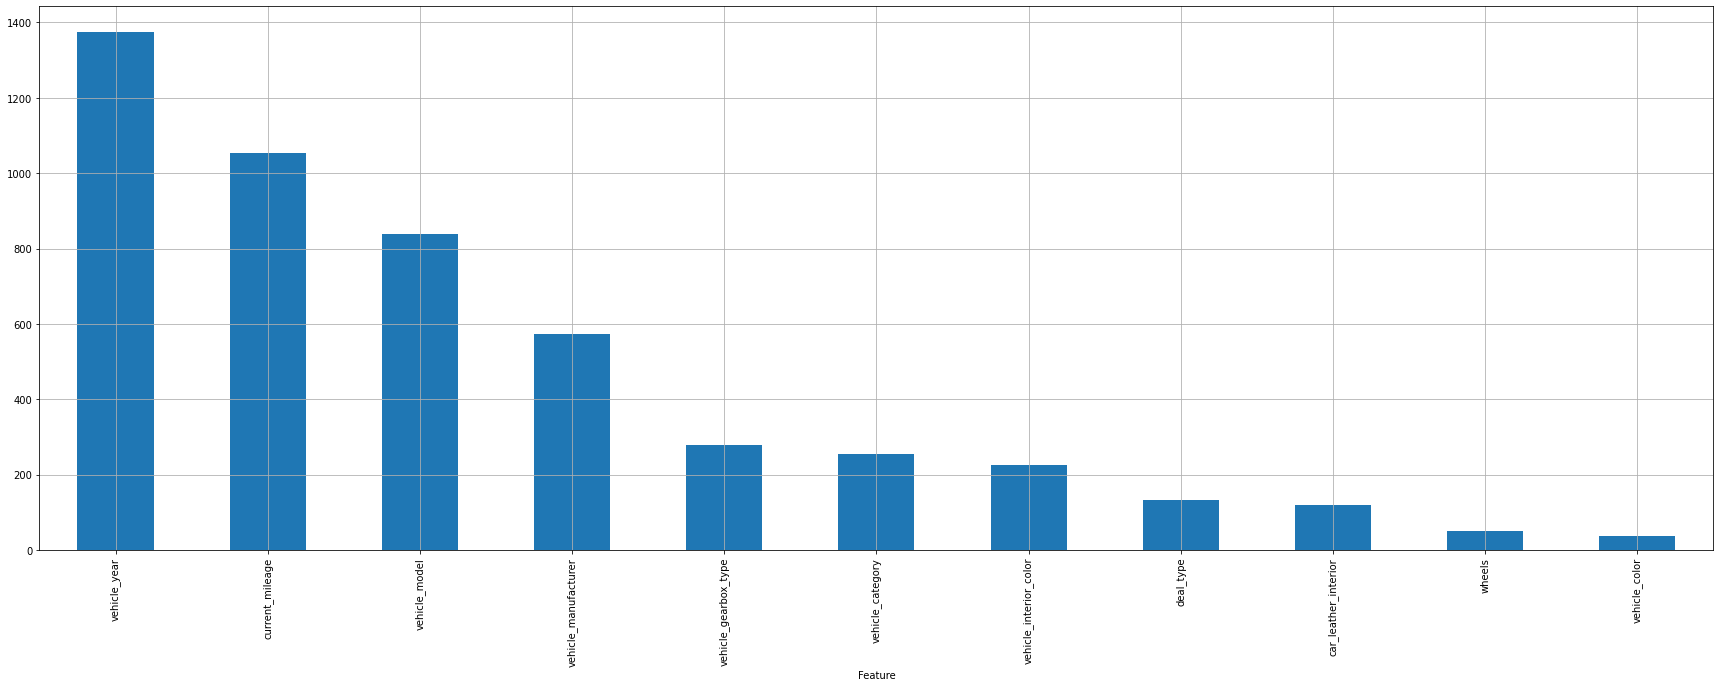

In [26]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [27]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2883.5947],
       [ 6190.4844],
       [ 8237.696 ],
       ...,
       [17576.377 ],
       [ 5187.6807],
       [ 6427.2197]], dtype=float32)
Shape = (10697, 1)


In [28]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('submission.csv', index = False)
#tr_data.to_csv('train_data_dd.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [29]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
